In [1]:
import numpy as np
import functions as fc
from timeit import default_timer as time
from fatiando.gravmag import polyprism, sphere
from fatiando import mesher, gridder,utils
from fatiando.constants import G, SI2MGAL
from scipy.sparse import diags
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
from scipy import interpolate
from fatiando.vis import mpl
%matplotlib inline

C:\ProgramData\Anaconda2\lib\site-packages\fatiando\vis\mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


## Create the model

In [6]:
# Polygonal Prism model
verts1 = [[-500, -3000], [0, -3500], [4500, 0], [4000, 500]]
verts2 = [[4000, -3000], [4500, -2500], [0, 3500], [-500, 3000]]

model_prism = [mesher.PolygonalPrism(verts1, 900., 1500., props={'density':350}),
               mesher.PolygonalPrism(verts2, 1600., 2200., props={'density':400})]
R = 1000 #Radius
xc, yc, zc = -3000.,0.,2000. #Center of sphere
model_sphere = [mesher.Sphere(xc, yc, zc,R, props={'density':-500})]

## Grid and Forward model

In [7]:
# Create a regular grid at 0m height
shape = (100, 100)
area = [-5000, 5000, -4000, 4000]
xi, yi, zi = gridder.regular(area, shape, z=-100.)
print (area[1]-area[0])/(shape[0]-1.)

# Vertical component of the gravitational atraction observed
dobs_prism = polyprism.gz(xi, yi, zi, model_prism)
dobs_sphere = sphere.gz(xi, yi, zi, model_sphere)
dobs_0 = dobs_sphere + dobs_prism
dobs = utils.contaminate(dobs_0, 0.005, seed=0, percent=True)

101.01010101


In [8]:
np.std(dobs-dobs_0)

0.01486034803536794

## True data plot

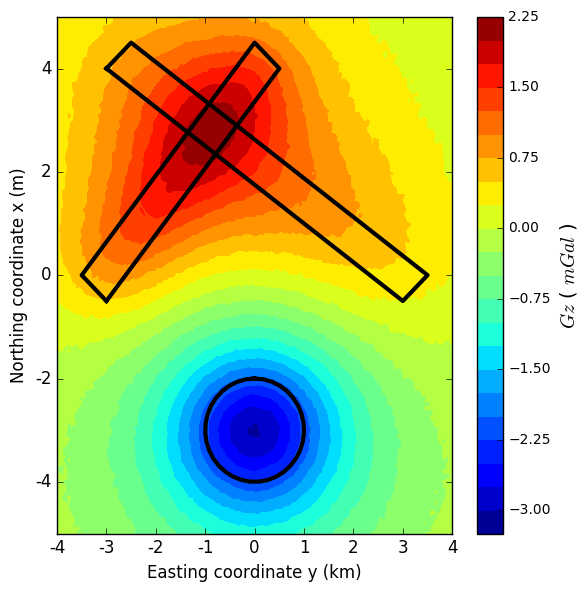

In [4]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc + R*np.cos(phi)
y = yc + R*np.sin(phi)

x_p = [-3000., -3500,0,500,-3000.]
y_p = [-500., 0,4500,4000,-500.]

x_p2 = [-3000, -2500,3500,3000,-3000.]
y_p2 = [4000, 4500,0,-500,4000]

# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6,6))

plt.plot()
plt.tricontourf(yi,xi,dobs,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
#plt.plot(yi, xi, 'ko-', alpha=0.1)
plt.tight_layout(True)
#plt.savefig('figures/synthetic_data.png', dpi=300)

## Equivalent Layer Depth

In [9]:
# Equivalent Layer depth
zj = np.ones_like(zi)*300

## Fast Eq. Layer

In [10]:
# Predicted data
itmax = 40
s = time()
rho, gzp = fc.fast_eq(xi,yi,zi,zj,shape,dobs,itmax)
e = time()
tcpu = e - s
print tcpu, 'seconds'

9.4380408922 seconds


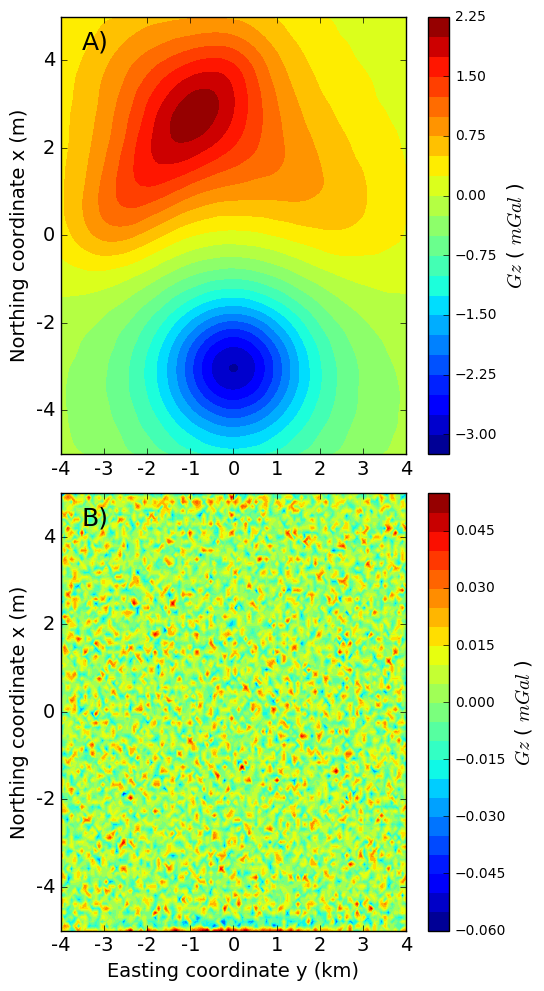

In [17]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(5.5,10))

#plt.subplot(311)
#plt.title('A)', y=0.91, x=0.1, fontsize=18)
#plt.tricontourf(yi,xi,dobs,22,cmap='jet')
#cb = plt.colorbar(shrink=1)
##plt.axis('scaled')
#cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
#plt.xlim(np.min(yi),np.max(yi))
#plt.ylim(np.min(xi),np.max(xi))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
##plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
#mpl.m2km()

plt.subplot(211)
plt.title('A)', y=0.91, x=0.1, fontsize=18)
plt.tricontourf(yi,xi,gzp,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz = gzp-dobs
plt.subplot(212)
plt.title('B)', y=0.91, x=0.1, fontsize=18)
plt.tricontourf(yi,xi,delta_gz,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('figures/classic_fast_val.png', dpi=300)

In [12]:
mean = np.mean(delta_gz)
print mean
std = np.std(delta_gz)
print std

-8.26361300238e-07
0.0144351387853


## Fast Eq. Layer BCCB

In [13]:
# Predicted data
itmax = 40
s = time()
rho_c, gzp_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape,dobs,itmax)
e = time()
tcpu = e - s
print tcpu, 'seconds'

0.112221330486 seconds


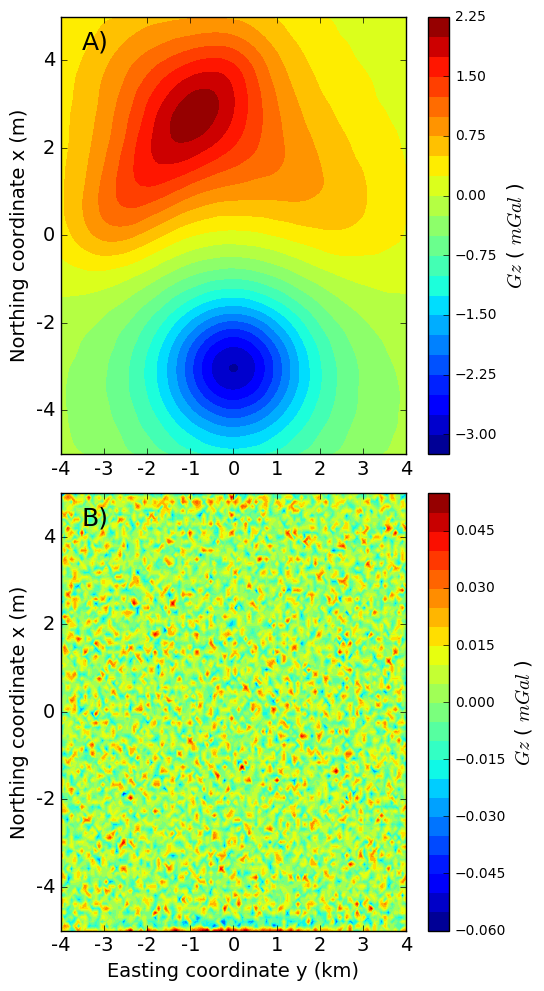

In [19]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(5.5,10))

#plt.subplot(311)
#plt.title('A)', y=0.91, x=0.1, fontsize=18)
#plt.tricontourf(yi,xi,dobs,22,cmap='jet')
#cb = plt.colorbar(shrink=1)
##plt.axis('scaled')
#cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
#plt.xlim(np.min(yi),np.max(yi))
#plt.ylim(np.min(xi),np.max(xi))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
##plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
#mpl.m2km()

plt.subplot(211)
plt.title('A)', y=0.91, x=0.1, fontsize=18)
plt.tricontourf(yi,xi,gzp_bccb,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz = gzp_bccb-dobs
plt.subplot(212)
plt.title('B)', y=0.91, x=0.1, fontsize=18)
plt.tricontourf(yi,xi,delta_gz,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('figures/bccb_fast_val.png', dpi=300)

In [11]:
mean = np.mean(delta_gz)
print mean
std = np.std(delta_gz)
print std

-8.26361300233e-07
0.0144351387853


## Mass distribution plot

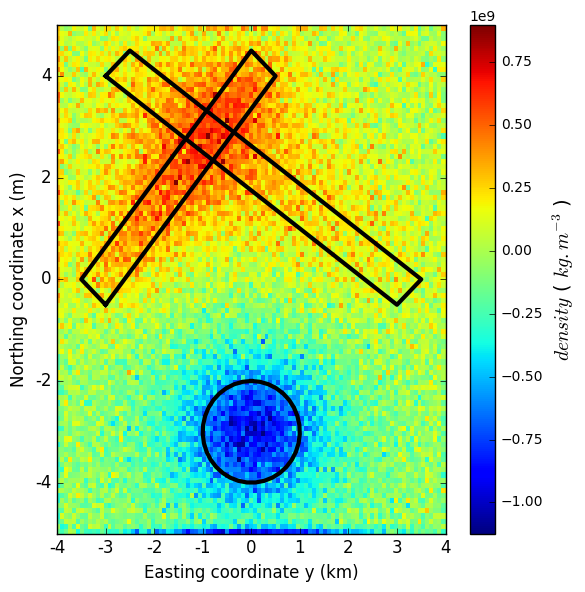

In [19]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc + R*np.cos(phi)
y = yc + R*np.sin(phi)

x_p = [-3000., -3500,0,500,-3000.]
y_p = [-500., 0,4500,4000,-500.]

x_p2 = [-3000, -2500,3500,3000,-3000.]
y_p2 = [4000, 4500,0,-500,4000]

plt.figure(figsize=(6,6))

plt.plot()
plt.pcolormesh(yi.reshape(shape), xi.reshape(shape),
               rho_c.reshape(shape))
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$density$ ( $kg.m^{-3}$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
#plt.plot(yi, xi, 'ko-', alpha=0.1)
plt.tight_layout(True)
plt.savefig('figures/mass_distribution_bccb.png', dpi=300)
plt.show()

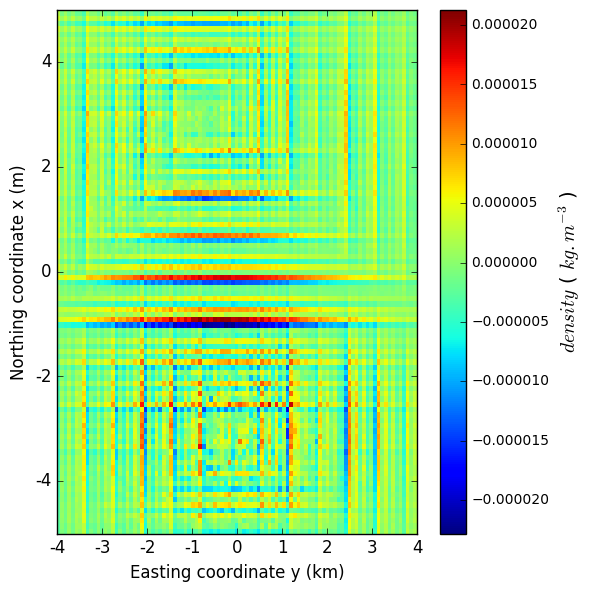

In [20]:
plt.figure(figsize=(6,6))
delta_rho = rho-rho_c
plt.plot()
plt.pcolormesh(yi.reshape(shape), xi.reshape(shape),
               delta_rho.reshape(shape))
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$density$ ( $kg.m^{-3}$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('figures/delta_rho.png', dpi=300)
plt.show()

## Comparison Fast Vs BCCB

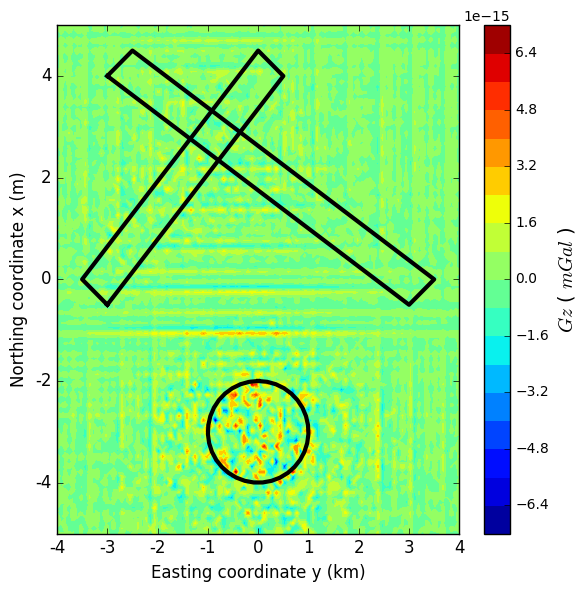

In [24]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6,6))
delta_gzp = gzp-gzp_bccb
plt.plot()
plt.tricontourf(yi,xi,delta_gzp,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar()
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('figures/delta_comparison.png', dpi=300)
#plt.plot(yi, xi, 'ko-', alpha=0.1)

In [15]:
mean = np.mean(delta_gzp)
print mean
std = np.std(delta_gzp)
print std

-4.62193488777e-18
8.66021031771e-16


## Upward Continuation and Downward Continuation

In [16]:
N = shape[0]*shape[1]

#up
s = time()
zi_up = np.ones_like(zi)*-300
BTTB_up = fc.bttb(xi,yi,zi_up,zj)
cev_up = fc.bccb(shape,N,BTTB_up)
gzp_bccb_up = fc.fast_forward_bccb(shape,N,rho_c,cev_up)
e = time()
tcpu = e - s
print tcpu, 'seconds'

s = time()
A = fc.sensibility_matrix(xi,yi,zi_up,zj,N)
gzp_up = A.dot(rho)
e = time()
tcpu = e - s
print tcpu, 'seconds'


#down
s = time()
zi_down = np.ones_like(zi)*-50
BTTB_down = fc.bttb(xi,yi,zi_down,zj)
cev_down = fc.bccb(shape,N,BTTB_down)
gzp_bccb_down = fc.fast_forward_bccb(shape,N,rho_c,cev_down)
e = time()
tcpu = e - s
print tcpu, 'seconds'

s = time()
A = fc.sensibility_matrix(xi,yi,zi_down,zj,N)
gzp_down = A.dot(rho)
e = time()
tcpu = e - s
print tcpu, 'seconds'

0.00894535170148 seconds
7.66918535033 seconds
0.00722020116778 seconds
7.47686199936 seconds


### Upward plot

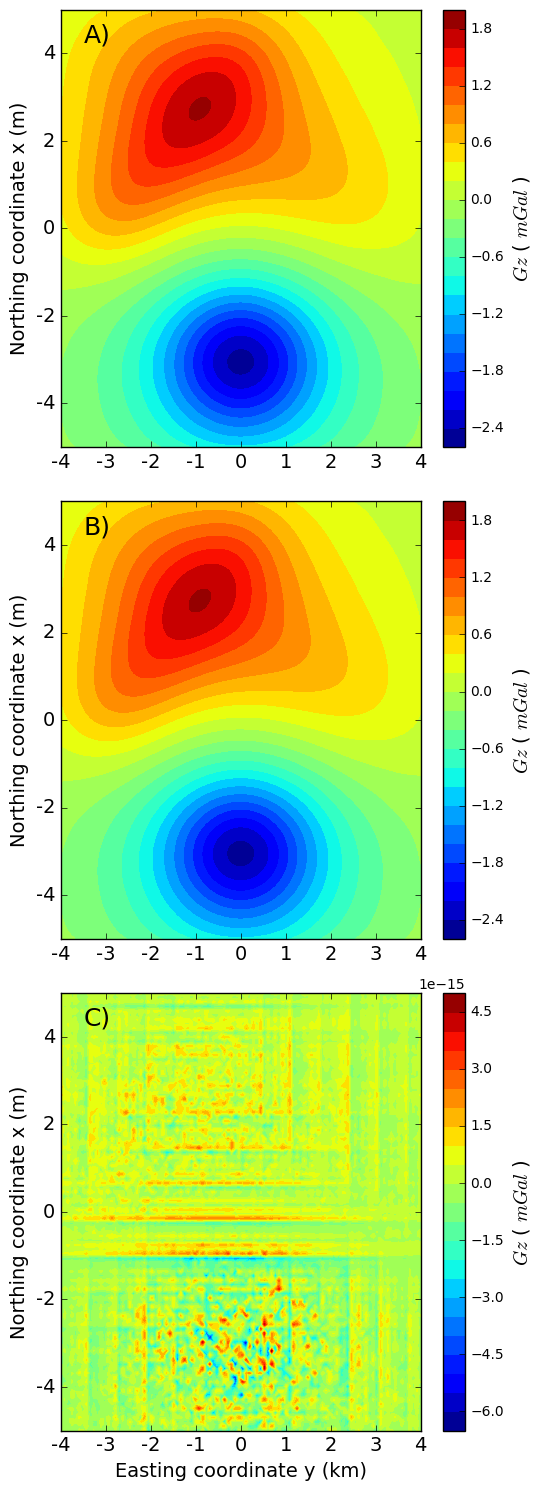

In [25]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(5.5,15))

plt.subplot(311)
plt.title('A)', y=0.91, x=0.1, fontsize=18)
plt.tricontourf(yi,xi,gzp_up,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.subplot(312)
plt.title('B)', y=0.91, x=0.1, fontsize=18)
plt.tricontourf(yi,xi,gzp_bccb_up,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz_up = gzp_bccb_up-gzp_up
plt.subplot(313)
plt.title('C)', y=0.91, x=0.1, fontsize=18)
plt.tricontourf(yi,xi,delta_gz_up,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('figures/upward_comparison.png', dpi=300)

In [18]:
mean = np.mean(delta_gz_up)
print mean
std = np.std(delta_gz_up)
print std

-5.93786630108e-18
8.70144258307e-16


### Downward plot

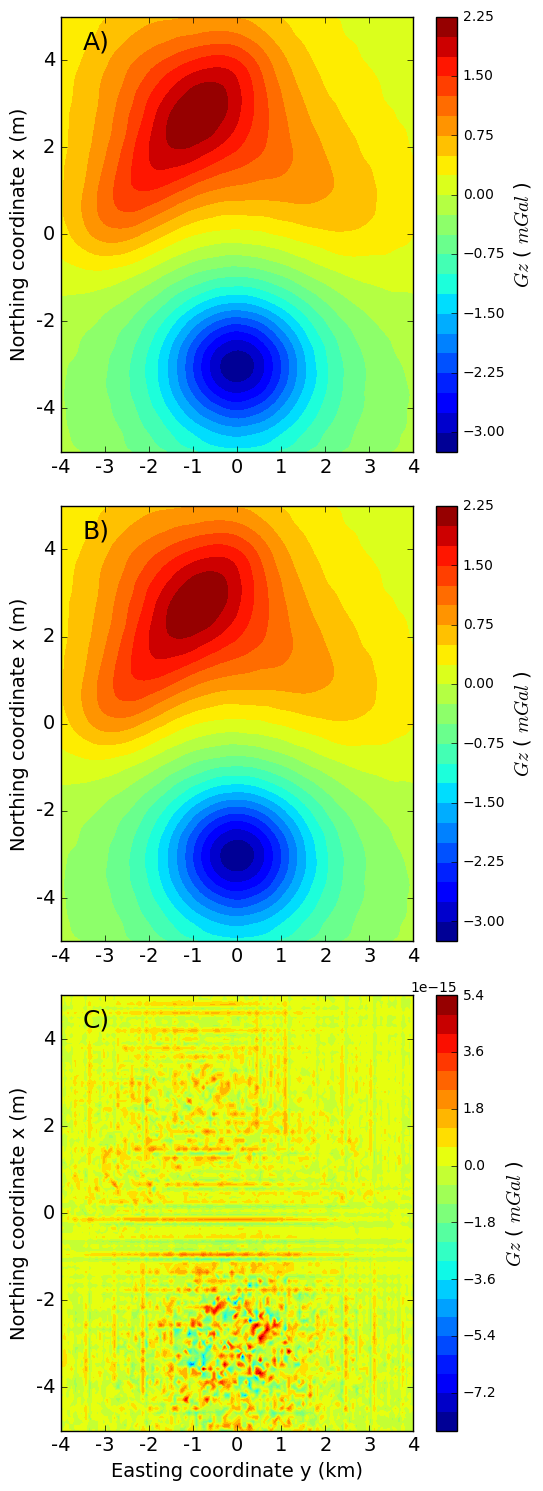

In [26]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(5.5,15))

plt.subplot(311)
plt.title('A)', y=0.91, x=0.1, fontsize=18)
plt.tricontourf(yi,xi,gzp_down,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.subplot(312)
plt.title('B)', y=0.91, x=0.1, fontsize=18)
plt.tricontourf(yi,xi,gzp_bccb_down,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz_down = gzp_bccb_down-gzp_down
plt.subplot(313)
plt.title('C)', y=0.91, x=0.1, fontsize=18)
plt.tricontourf(yi,xi,delta_gz_down,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('figures/downward_comparison.png', dpi=300)

In [20]:
mean = np.mean(delta_gz_down)
print mean
std = np.std(delta_gz_down)
print std

5.91393253813e-18
9.0149472025e-16


## FLOPS - Fast equivalent layer Vs BCCB

In [2]:
N = np.arange(10000.,1000000,10000)
it = 50
old = it*(3*N + 2*N**2)

In [3]:
new = 4*N*np.log2(4*N) + it*(7*N + 8*N*np.log2(4*N))

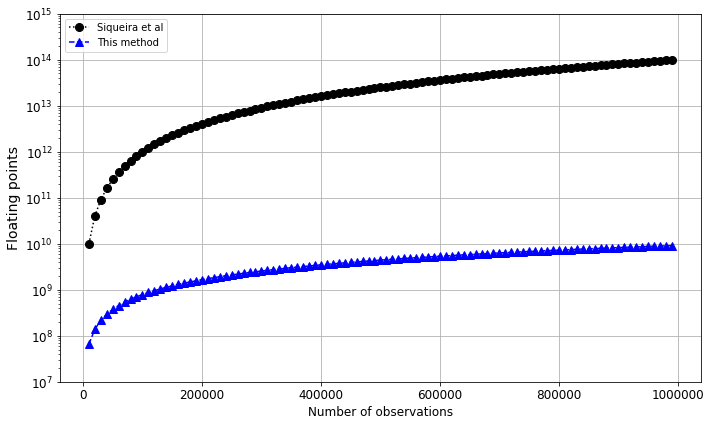

In [4]:
plt.figure(figsize=(10,6))

plt.semilogy(N, old, 'ko:', alpha=1, markersize=8, label='Siqueira et al')
plt.semilogy(N, new, 'b^--', alpha=1, markersize=8, label='This method')
#plt.axis('scaled')
#plt.xlim(np.min(N)-1,np.max(N)+1)
plt.ylim(10**7,10**15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Number of observations', fontsize=12)
plt.ylabel('Floating points', fontsize=14)
plt.grid(True)
plt.tight_layout(True)
plt.legend(loc='upper left')
#plt.savefig('figures/float.png', dpi= 500)

## Time Vs Observation points

In [9]:
time_old = [0.0022009884490898912, 0.6933698073992218,9.392905233477336]

In [19]:
time_old = []
N_time_0 = []
shape_0 = [(10,10),(20,20),(30,30),(40,40),(50, 50),(60,60),(70,70),(80,80),(90,90),(100, 100),(150, 150)]
#shape_0 = [(200, 200)]
for i in range(len(shape_0)):
    # Create a regular grid at 0m height
    area = [-5000, 5000, -4000, 4000]
    xi, yi, zi = gridder.regular(area, shape_0[i], z=100.)
    #delta_s  = (area[1]-area[0])/(shape[i][0]-1.)

    # Vertical component of the gravitational atraction observed
    dobs_prism = polyprism.gz(xi, yi, zi, model_prism)
    dobs_sphere = sphere.gz(xi, yi, zi, model_sphere)
    dobs = dobs_sphere + dobs_prism
    dobs = utils.contaminate(dobs, 0.005, seed=0, percent=True)

    zj = np.ones_like(zi)*300

    itmax = 50
    s = time()
    rho, gzp = fc.fast_eq(xi,yi,zi,zj,shape_0[i],dobs,itmax)
    e = time()
    tcpu_0 = e - s
    time_old.append(tcpu_0)
    n_shape_0 = shape_0[i][0]*shape_0[i][1]
    N_time_0.append(n_shape_0)

In [17]:
time_new = []
N_time = []
#shape = [(10,10),(50, 50),(100, 100),(200, 200),(300, 300),(400, 400),(500, 500),(1000, 1000),(1500,1500),(2000, 2000)]
shape = [(10,10),(20,20),(30,30),(40,40),(50, 50),(60,60),(70,70),(80,80),(90,90),(100, 100),(150, 150)]
for i in range(len(shape)):
    # Create a regular grid at 0m height
    area = [-5000, 5000, -4000, 4000]
    xi, yi, zi = gridder.regular(area, shape[i], z=100.)
    #delta_s  = (area[1]-area[0])/(shape[i][0]-1.)

    # Vertical component of the gravitational atraction observed
    dobs_prism = polyprism.gz(xi, yi, zi, model_prism)
    dobs_sphere = sphere.gz(xi, yi, zi, model_sphere)
    dobs = dobs_sphere + dobs_prism
    dobs = utils.contaminate(dobs, 0.005, seed=0, percent=True)

    zj = np.ones_like(zi)*300

    itmax = 50
    s = time()
    rho_c, gzp_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape[i],dobs,itmax)
    e = time()
    tcpu = e - s
    time_new.append(tcpu)
    n_shape = shape[i][0]*shape[i][1]
    N_time.append(n_shape)

In [63]:
time_old

[0.00237404341180536,
 0.021676581559859187,
 0.07415728158775892,
 0.2801750411545072,
 0.6855157977806812,
 1.2651932221017432,
 2.354004170470489,
 3.9442400580695676,
 6.298112796570081,
 9.532224781170044,
 48.31462105112507]

In [96]:
time_new

[0.0031669117591945906,
 0.007024625390386063,
 0.0132655056937665,
 0.018785933529102294,
 0.028284102889870155,
 0.037558752371410264,
 0.08802378205894001,
 0.07358308638754352,
 0.0863185876736452,
 0.12843383840083789,
 0.4732257967029909]

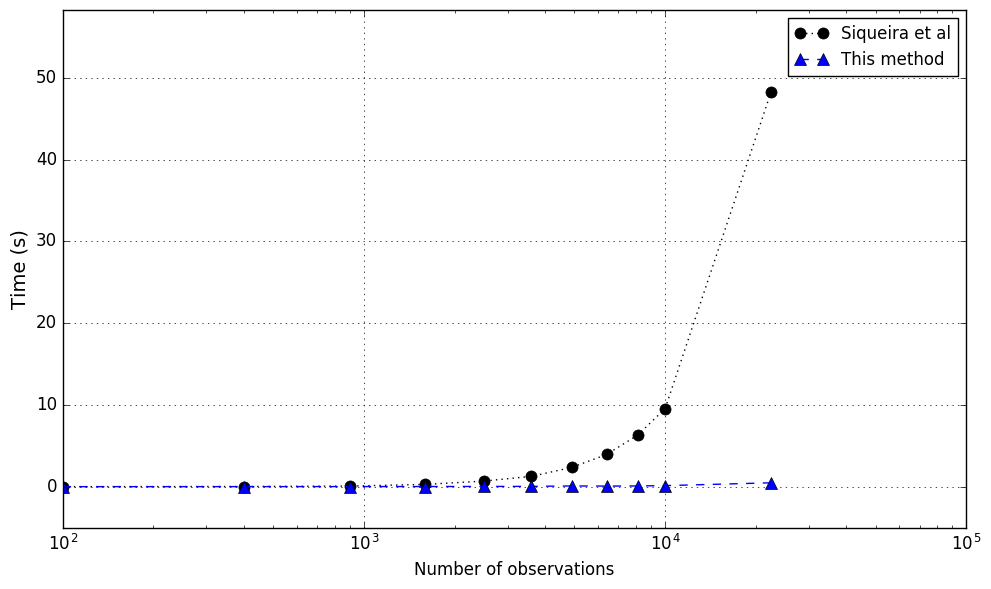

In [34]:
plt.figure(figsize=(10,6))
plt.semilogx(N_time_0, time_old, 'ko:', alpha=1, markersize=8, label='Siqueira et al')
plt.semilogx(N_time, time_new, 'b^--', alpha=1, markersize=8, label='This method')
#plt.axis('scaled')
#plt.xlim(np.min(N_time)-1,np.max(N_time)+1)
plt.ylim(np.min(time_new)-5,np.max(time_old)+10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Number of observations', fontsize=12)
plt.ylabel('Time (s)', fontsize=14)
plt.grid(True)
plt.tight_layout(True)
plt.legend(loc='best')
#plt.savefig('figures/time_comparison.png', dpi= 500)

In [ ]:
time_new_n = [0.003339113298807206, 0.032924991404115644, 0.10850721222254833, 0.9457502427642339, 2.1735934070759413,
 4.279113891931502, 6.59717241650651, 26.821107974356664, 65.04334746108202, 117.47089252286105]

N_time_n = [100, 2500, 10000, 40000, 90000, 160000, 250000, 1000000, 2250000, 4000000]

In [28]:
#time_new_n = []
#N_time_n = []
#shape_n = [(10,10),(50, 50),(100, 100),(200, 200),(300, 300),(400, 400),(500, 500),(1000, 1000),(1500,1500),(2000, 2000)]
shape_n = [(3000, 3000),(4000,4000),(5000,5000)]
for i in range(len(shape_n)):
    # Create a regular grid at 0m height
    area = [-5000, 5000, -4000, 4000]
    xi, yi, zi = gridder.regular(area, shape_n[i], z=100.)
    #delta_s  = (area[1]-area[0])/(shape[i][0]-1.)

    # Vertical component of the gravitational atraction observed
    dobs_prism = polyprism.gz(xi, yi, zi, model_prism)
    dobs_sphere = sphere.gz(xi, yi, zi, model_sphere)
    dobs = dobs_sphere + dobs_prism
    dobs = utils.contaminate(dobs, 0.005, seed=0, percent=True)

    zj = np.ones_like(zi)*300

    itmax = 50
    s = time()
    rho_c, gzp_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape_n[i],dobs,itmax)
    e = time()
    tcpu_n = e - s
    time_new_n.append(tcpu_n)
    n_shape_n = shape_n[i][0]*shape_n[i][1]
    N_time_n.append(n_shape_n)

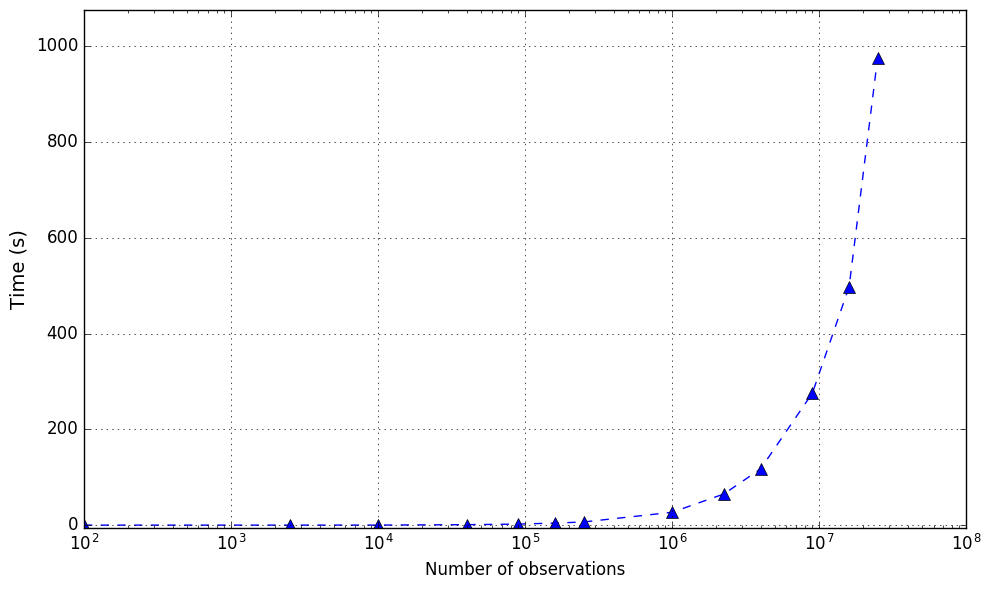

In [32]:
plt.figure(figsize=(10,6))
plt.semilogx(N_time_n, time_new_n, 'b^--', alpha=1, markersize=8, label='This method')
#plt.axis('scaled')
#plt.xlim(np.min(N_time)-1,np.max(N_time)+1)
plt.ylim(np.min(time_new_n)-5,np.max(time_new_n)+100)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Number of observations', fontsize=12)
plt.ylabel('Time (s)', fontsize=14)
plt.grid(True)
plt.tight_layout(True)
#plt.legend(loc='best')
#plt.savefig('figures/time_bccb.png', dpi= 500)

In [112]:
(1000000.*8*8)/(1024*1024)

61.03515625

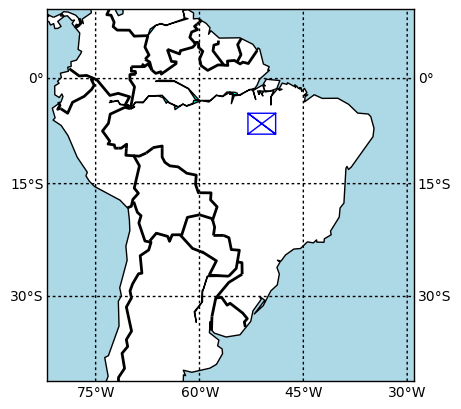

In [31]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

def plot_rec(bmap, lower_left, upper_left, lower_right, upper_right):
    xs = [lower_left[0], upper_left[0],
          lower_right[0], upper_right[0],
          lower_left[0], lower_right[0],
          upper_left[0], upper_right[0]]
    ys = [lower_left[1], upper_left[1],
          lower_right[1], upper_right[1],
          lower_left[1], lower_right[1],
          upper_left[1], upper_right[1]]
    bmap.plot(xs, ys, latlon = True)

# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# lat_ts is the latitude of true scale.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='merc',llcrnrlat=-40,urcrnrlat=10,\
            llcrnrlon=-82,urcrnrlon=-29,lat_ts=20,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='white',lake_color='aqua')

llcrnrlon = -53
urcrnrlon =  -49
llcrnrlat =  -8
urcrnrlat =  -5
lower_left = (llcrnrlon, llcrnrlat)
lower_right= (urcrnrlon, llcrnrlat)
upper_left = (llcrnrlon, urcrnrlat)
upper_right= (urcrnrlon, urcrnrlat)
plot_rec(m, lower_left, upper_left, lower_right, upper_right)

# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,15.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,15.),labels=[False,False,False,True],dashes=[2,2])
m.drawmapboundary(fill_color='lightblue')
m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
#m.drawstates(linewidth=0.5, linestyle='solid', color='k')
#plt.title("Mercator Projection")
plt.tight_layout(True)
plt.savefig('figures/projection.png', dpi= 500)
plt.show()